# Ensemble Learning

## Initial Imports

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [46]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## Read the CSV and Perform Basic Data Cleaning

In [47]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [48]:
# Create our features
X = df.drop(columns='loan_status')
X = pd.get_dummies(X)

# Create our target
y = df['loan_status']
y = y.to_frame()

In [49]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [50]:
# Check the balance of our target values
# YOUR CODE HERE

y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [51]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [52]:
# Create the StandardScaler instance
# YOUR CODE HERE

from sklearn.preprocessing import StandardScaler

Sscaler = StandardScaler()

In [53]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
# YOUR CODE HERE

X_scaler = Sscaler.fit(X_train)


In [54]:
# Scale the training and testing data
# YOUR CODE HERE

X_train_scale = X_scaler.transform(X_train)
X_test_scale = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [55]:
# Resample the training data with the BalancedRandomForestClassifier
# YOUR CODE HERE

from imblearn.ensemble import BalancedRandomForestClassifier
BRFClassifier = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
BRFClassifier.fit(X_train_scale, y_train)

BalancedRandomForestClassifier(random_state=1)

In [56]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

y_predict = BRFClassifier.predict(X_test_scale)


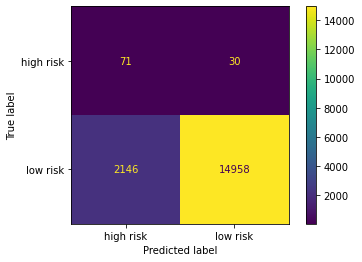

In [58]:
# Display the confusion matrix
# YOUR CODE HERE

confusmat = confusion_matrix(y_test, y_predict)
disp= ConfusionMatrixDisplay(confusion_matrix=confusmat, display_labels=['high risk', 'low risk'])
disp.plot();

In [59]:
# Print the imbalanced classification report
# YOUR CODE HERE

print(classification_report_imbalanced(y_test, y_predict))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.70      0.87      0.06      0.78      0.60       101
   low_risk       1.00      0.87      0.70      0.93      0.78      0.63     17104

avg / total       0.99      0.87      0.70      0.93      0.78      0.63     17205



In [60]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE

feature_importances = BRFClassifier.feature_importances_

### Easy Ensemble Classifier

In [61]:
# Train the Classifier
# YOUR CODE HERE

from imblearn.ensemble import EasyEnsembleClassifier

easy_ensemble = EasyEnsembleClassifier(n_estimators=100, random_state=1)
easy_ensemble.fit(X_train_scale, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [64]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

ee_predict = easy_ensemble.predict(X_test_scale)
ee_bac = balanced_accuracy_score(y_test, ee_predict)

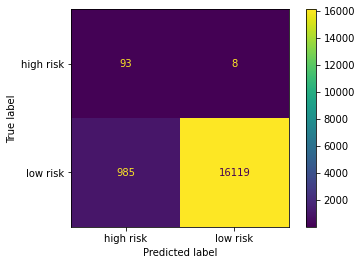

In [65]:
# Display the confusion matrix
# YOUR CODE HERE

ee_confusmat = confusion_matrix(y_test, ee_predict)
disp= ConfusionMatrixDisplay(confusion_matrix=ee_confusmat, display_labels=['high risk', 'low risk'])
disp.plot();

In [66]:
# Print the imbalanced classification report
# YOUR CODE HERE

print(classification_report_imbalanced(y_test, ee_predict))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    YOUR ANSWER HERE.

2. Which model had the best recall score?

    YOUR ANSWER HERE.

3. Which model had the best geometric mean score?

    YOUR ANSWER HERE.

4. What are the top three features?

    YOUR ANSWER HERE.

# Question 1: The model with the best balanced accuracy score was The Easy Ensemble.

# Question 2: The model with the best recall score was Easy Ensemble. 

# Question 3: The top three features were:
   # (1) total_rec_prncp, (2) total_pymnt and (3) total_pymnt_inv.